In [1]:
from __future__ import division
import sys
sys.path = ['..'] + sys.path

import os
import numpy as np
import visualizer as viz
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Import Data

Provide a path to the numpy data:

In [2]:
IMPORT_PATH = '/Volumes/DATA/Datasets/Geography_Data/evi/benin/'

Load the numpy data into memory:

In [3]:
data = viz.import_numpy_files(IMPORT_PATH)
#dir(viz)

###Handle Missing Data

In [4]:
from missing_data import replace_missing_values, missing_ratio

In [5]:
for date in data.keys():
    missing_data_ratio = missing_ratio(data[date])        
    #Replace missing data with average of neighbours
    if missing_data_ratio:
        data[date] = replace_missing_values(data[date])

###Create Benin Outline

Provide a path to the shapefile for Benin:

In [6]:
#SHAPE_PATH = '/Users/samuelalbanie/Downloads/BEN_adm/BEN_adm0.shp'
SHAPE_PATH = '/private/tmp/BEN_adm_shp/BEN_adm0.shp'

Load country outline:

In [7]:
(line_x, line_y) = viz.country_outline(SHAPE_PATH)

### Evi 

We need to divide all terms by 10000 to retrieve percentages

In [9]:
for date in data.keys():
    data[date] = data[date] / 10000

Hardcoded parameters for the visualization:

In [10]:
x_offset = 3613
y_offset = 1550
array_height, array_width = data[data.keys()[0]].shape
viz_width = 5
aspect_ratio = array_width / array_height
viz_height = viz_width / aspect_ratio

Offset the country outline to match up with the raster data:

In [11]:
offset_line_x = [x - x_offset for x in line_x]
offset_line_y = [y - y_offset for y in line_y]

In [14]:
dates = sorted([date for date in data.keys()])

In [15]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

In [16]:
def build_evi_map(date, data):
    monthly_data = data[date]
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ocean = np.ma.masked_array(monthly_data, monthly_data != -0.9999)
    ocean_map = plt.pcolormesh(ocean, vmin=-1, vmax=-0.9998, alpha=1, cmap="Blues", zorder=10)
    temp_map = plt.pcolor(monthly_data, cmap=plt.cm.BrBG,norm=plt.Normalize(0, 0.8))
    month_label = plt.text(35, 127, 'date: ' + date, fontsize=12, zorder=20)
    return (temp_map,ocean_map, month_label) #boundary, 

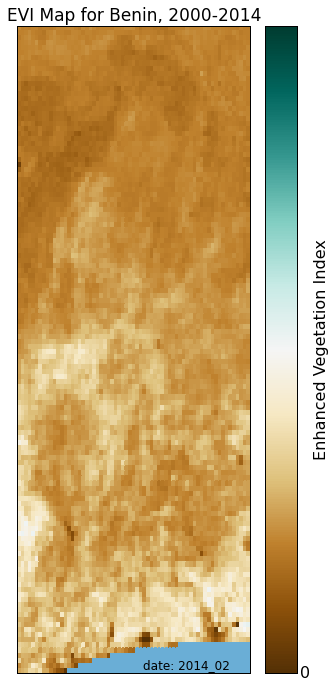

In [17]:
import numpy as np

dpi = 100

fig = plt.figure()
fig.set_size_inches(viz_width, viz_height)
plt.xlim(xmax=array_width)
plt.ylim(ymax=array_height)
    
heatmaps = []
x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x,y)

for i, date in enumerate(dates):
    heatmaps.append(build_evi_map(date, data))

cbar = plt.colorbar()
boundary = plt.plot(offset_line_x, offset_line_y, c='k', linewidth=1, linestyle='-', dash_capstyle='projecting', zorder=5)
cbar.set_ticks([0, 1])
cbar.set_label('Enhanced Vegetation Index')
plt.gca().invert_yaxis()
plt.gca().set_title("EVI Map for Benin, 2000-2014", fontsize=17)
map_ani = animation.ArtistAnimation(fig, heatmaps, interval=100, repeat=True, repeat_delay=None, blit=True)
writer = animation.writers['ffmpeg'](fps=12, bitrate=1800)
plt.tight_layout()
plt.grid()

map_ani.save('benin_evi.mp4', dpi=dpi)
plt.show()

### Gather statistics

In [ ]:
import numpy.ma as ma

def temp_stats(month, data):
    masked = ma.masked_less_equal(data[month], -0.01)
    stats = {
        'min': np.amin(masked),
        'max': np.amax(masked),
        'avg': ma.average(masked)
    }
    return stats

In [ ]:
min_temps = []
max_temps = []
avg_temps = []
for date in dates:
    min_temps.append(temp_stats(date, data)['min'])
    max_temps.append(temp_stats(date, data)['max'])
    avg_temps.append(temp_stats(date, data)['avg'])

In [ ]:
import pandas as pd
from datetime import date

In [ ]:
start = date(2000,1,1)
end = date(2014,2,1)
range_of_dates = pd.date_range(start, end, freq='M')
x_dates = range_of_dates.to_pydatetime()

In [ ]:
DARK_GREEN = '#339933'
LIGHT_GREEN = '#99CC00'

In [ ]:
import matplotlib.lines as mlines
import matplotlib.dates as dates
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib import colors

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title("EVI Across Benin, 2000 - 2014", fontsize=20)

ax.set_xlim(xmin=start, xmax=end) 

ax.plot_date(x_dates, max_temps, '-', color=DARK_GREEN)
ax.plot_date(x_dates, avg_temps, '-', color=LIGHT_GREEN)
ax.set_ylabel("Enhanced Vegetation Index", fontsize=14)

ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.grid()
plt.tight_layout()

max_line = mlines.Line2D([], [], color=DARK_GREEN, markersize=10, label='maximum')
avg_line = mlines.Line2D([], [], color=LIGHT_GREEN, markersize=10, label='average')
legend = plt.legend(handles=[max_line, avg_line], fontsize=12, loc='lower right')
plt.savefig('Benin_evi_plot.png')
plt.show()
